# Publication case study
<font size="3">_By Joris Baars, Newcastle University, UK, 2022_ (joris.baars@hotmail.com) <br>

The following notebook is used to model the cost, carbon footprint, performance and material criticality of different battery designs. Multi-objective optimisation is used to identify optimal design.
    The results are published in:

    ADD PUBLICATION

<!--     Baars, Joris & Heidrich, Oliver  -->


In [2]:
#Import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging as log
import sys, os
import copy
import pyomo.environ as pyo
import sys
import openpyxl
from tqdm import tqdm
import pkg_resources

%matplotlib inline

The ODYM, battery cost and emission scripts need to be imported locally. The ODYM (Open Dynamic Material Systems Model) model is used to establish a general system and data structure and import all parameters. The latest ODYM version can be found here: https://github.com/IndEcol/ODYM


In [3]:
# Local scripts
# path to ODYM:
sys.path.insert(
    0,
    os.path.join(
        r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\ME_battery_supply_chain\Model\ODYM"
    ),
)
import ODYM_Classes as msc
import ODYM_Functions as msf

# Path to battery cost and LCA:
# Import the battery design module from a local path
local_path = (
    r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Bat_Sust_Model"  # ADD PATH
)
sys.path.insert(1, local_path)
from batt_sust_model import battery_emissions as bat_lca
from batt_sust_model import battery_cost as bat_cost

# Logfile ODYM
log_verbosity = eval("log.INFO")
log_filename = "log_file.md"
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(), log_verbosity, log_verbosity)


# Local path to all case study parameter files:
datapath = "."


# <b> STEP 1.</b> Data model setup
In the following block, the index table and parameter dictionary are established. This step is based on the first two steps of a ODYM model run (initialization and classification and data read). More details can be found [here](https://github.com/IndEcol/ODYM/wiki/The-ODYM-project-script) and a tutorial can be found [here](https://github.com/IndEcol/ODYM/blob/master/docs/ODYM%20Example%20and%20Tutorial%20No.%204.%20ODYM_Database.ipynb)

## Read config and classification file

In the first step, the model config (model_config.xlsx) and classification (model_classfication.xlsx) files are loaded


In [4]:
# Read config file and sheet
config_file = openpyxl.load_workbook(datapath + "\model_config.xlsx", data_only=True)
script_config = {"Model Setting": config_file["Cover"]["D4"].value}
config_sheet = config_file["Setting_" + script_config["Model Setting"]]
project_name = config_sheet["D2"].value
ScriptConfig = msf.ParseModelControl(config_sheet, script_config)

# Parse configfile
(
    IT_Aspects,
    IT_Description,
    IT_Dimension,
    IT_Classification,
    IT_Selector,
    IT_IndexLetter,
    PL_Names,
    PL_Description,
    PL_Version,
    PL_IndexStructure,
    PL_IndexMatch,
    PL_IndexLayer,
    PrL_Number,
    PrL_Name,
    PrL_Comment,
    PrL_Type,
    ScriptConfig,
) = msf.ParseConfigFile(config_sheet, script_config, Mylog)

# Load classification file and establish classification dictionary:
Classfile = openpyxl.load_workbook(datapath + "\model_classification.xlsx", data_only=True)
Classsheet = Classfile["MAIN_Table"]
MasterClassification = msf.ParseClassificationFile_Main(Classsheet, Mylog)

ModelClassification = {}  # Dict of model classifications
for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = copy.deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(":") > -1:  # range of items is taken
        RangeStart = int(EvalString[0 : EvalString.find(":")])
        RangeStop = int(EvalString[EvalString.find(":") + 1 : :])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]
    elif EvalString.find("[") > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [
            ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)
        ]
    elif EvalString == "all":
        None
    else:
        Mylog.info("ITEM SELECT ERROR for aspect " + IT_Aspects[m] + " were found in datafile.</br>")
        break


INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


## Establish index table

Next the index table is established. Each row of the index table consist of the model aspect, a unique index letter and the classification.


In [5]:
Mylog.info("Define index table dataframe")
IndexTable = pd.DataFrame(
    {
        "Aspect": IT_Aspects,  # 'Time' and 'Element' must be present!
        "Description": IT_Description,
        "Dimension": IT_Dimension,
        "Classification": [ModelClassification[Aspect] for Aspect in IT_Aspects],
        "IndexLetter": IT_IndexLetter,
    }
)  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index("Aspect", inplace=True)

# Add indexSize to IndexTable:
IndexTable["IndexSize"] = pd.Series(
    [len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
    index=IndexTable.index,
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

IndexTable


INFO (1689171678.py <<cell line: 1>>): Define index table dataframe


,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Regions,Battery production locations in Europe,Region,<ODYM_Classes.Classification object at 0x00000...,r,8
Process,All foreground processes,Process,<ODYM_Classes.Classification object at 0x00000...,p,146
Bat_process,Battery manufacturing process,Process,<ODYM_Classes.Classification object at 0x00000...,b,27
Goods,All foreground goods,Material,<ODYM_Classes.Classification object at 0x00000...,g,132
Internal_goods,Goods flowing inside factory,Material,<ODYM_Classes.Classification object at 0x00000...,i,15
Waste,Waste materials,Material,<ODYM_Classes.Classification object at 0x00000...,w,12
Energy,Electricity and heat,Energy,<ODYM_Classes.Classification object at 0x00000...,n,2
Elements,Chemical elements,Material,<ODYM_Classes.Classification object at 0x00000...,e,11
Emissions,ReCiPe Midpoint (H) V1.13 no LT,Satellite,<ODYM_Classes.Classification object at 0x00000...,h,17


The index table makes it easy to access the model classification items and assures that the order of the item lists is consistent throughout the model and data.<br><br> The classification items of the aspect **region** for example can be easily accessed:


In [6]:
IndexTable.loc["Regions", "Classification"].Items


['FR', 'DE', 'HU', 'NO', 'PL', 'SE', 'GB', 'European average']

In [7]:
# Index shortcuts:
r = IndexTable.loc["Regions", "Classification"].Items
p = IndexTable.loc["Process", "Classification"].Items
g = IndexTable.loc["Goods", "Classification"].Items
D = IndexTable.loc["Battery_designs", "Classification"].Items
P = IndexTable.loc["Technical_parameters", "Classification"].Items
bp = IndexTable.loc["Bat_process", "Classification"].Items
h = IndexTable.loc["Emissions", "Classification"].Items
f = IndexTable.loc["Factors", "Classification"].Items
e = IndexTable.loc["Elements", "Classification"].Items
p_electricity = [x for x in p if "market group for electricity battery production, medium voltage" in x]
p_gas = [x for x in p if "market group for heat, district or industrial, natural gas" in x]


## Load model parameters

Next, all model datasets are imported. All datasets are stored in Excel files using the [ODYM data file template](https://github.com/IndEcol/ODYM/wiki/Data-templates) and stored as Numpy arrays in the parameter dictionary. The following data sets are imported:

| Dataset name               | Description                                                                      |
| :------------------------- | :------------------------------------------------------------------------------- |
| 3_PR_factor_price          | Production factor price per unit                                                 |
| 3_PR_material_price_unit   | External material price per unit                                                 |
| 3_PR_material_price_mass   | External material price per mass of material in US dollar                        |
| 3_PR_mineral_price         | Mineral prices and scenarios                                                     |
| 3_PR_regional_energy_price | Regional electricity and gas price                                               |
| 3_MC_materials_pack_design | Material content of battery design                                               |
| 3_MC_element_goods         | Chemical elements in battery materials                                           |
| 3_PAR_battery_parameters   | Technical pararameters and Brightway Project Parameters for all battery designs  |
| 4_PY_battery_manufacturing | Battery process yield parameters for each scenario                               |
| 4_UPI_foreground_base      | Rectangular foreground good-process matrix of first battery design (base system) |
| 4_PE_modules_base          | Gate-to-gate emissions of base system modules                                    |
| 4_PE_sensitivity_materials | High and low GWP values for material extraction for senstivity analysis          |
| 4_PAR_energy_consumption   | Battery electricity consumption parameters for each scenario                     |
| 6_CR_ESSENZ_CF_elements    | ESSENZ supply risks characterisation factors for all considered elements         |


In [8]:
Mylog.info("Reading data files into ParameterDict")

ParameterDict = {}
mo_start = 0  # set mo for re-reading a certain parameter
for mo in range(mo_start, len(PL_Names)):
    # print (PL_Names[mo] )
    try:
        ParPath = os.path.join(datapath + "\Data\ODYM_database", PL_Names[mo] + "_" + PL_Version[mo])
        Mylog.info("Reading parameter " + PL_Names[mo])
        # Do not change order of parameters handed over to function!
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
        )
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    except ValueError:
        PL_Names[mo]
        Mylog.info(f"{PL_Names[mo]} includes strings")
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
            string_data=True,
        )  # Add string_data is True to include string dtype in np array.
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    #     Mylog.info('Current parameter file UUID: ' + MetaData['Dataset_UUID'])
    Mylog.info("_")
Mylog.info("Reading of parameters finished.")
print("ParameterDict loaded", ParameterDict)


INFO (4205885410.py <<cell line: 1>>): Reading data files into ParameterDict
INFO (4205885410.py <<cell line: 5>>): Reading parameter 3_PR_factor_price
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 93 values was read from file for parameter 3_PR_factor_price.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 24.0 of 24 values for parameter 3_PR_factor_price were assigned.
INFO (4205885410.py <<cell line: 5>>): _
INFO (4205885410.py <<cell line: 5>>): Reading parameter 3_PR_material_price_unit
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 23 values was read from file for parameter 3_PR_material_price_unit.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 23.0 of 10428 values for parameter 3_PR_material_price_unit were assigned.
INFO (4205885410.py <<cell line: 5>>): _
INFO (4205885410.py <<cell line: 5>>): Reading parameter 3_PR_material_price_mass
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 67 values was read from file for parameter 3_PR_material_price_mass.

ParameterDict loaded {'3_PR_factor_price': <ODYM_Classes.Parameter object at 0x000001B6150CABE0>, '3_PR_material_price_unit': <ODYM_Classes.Parameter object at 0x000001B61341AD00>, '3_PR_material_price_mass': <ODYM_Classes.Parameter object at 0x000001B617C361F0>, '3_PR_mineral_price': <ODYM_Classes.Parameter object at 0x000001B617CD9C70>, '3_PR_regional_energy_price': <ODYM_Classes.Parameter object at 0x000001B617BFFFA0>, '3_MC_materials_pack_design': <ODYM_Classes.Parameter object at 0x000001B618161F40>, '3_MC_element_goods': <ODYM_Classes.Parameter object at 0x000001B64A0D9790>, '3_PAR_battery_parameters': <ODYM_Classes.Parameter object at 0x000001B617C99310>, '4_PY_battery_manufacturing': <ODYM_Classes.Parameter object at 0x000001B644616A00>, '4_UPI_foreground_base': <ODYM_Classes.Parameter object at 0x000001B64A0FD0D0>, '4_PE_modules_base': <ODYM_Classes.Parameter object at 0x000001B617C991F0>, '4_PE_sensitivity_materials': <ODYM_Classes.Parameter object at 0x000001B644626190>, '4_

In [9]:
# Parameter shortcuts:
# dataframe of A default matrix:
df_A_base = pd.DataFrame(data=ParameterDict["4_UPI_foreground_base"].Values, index=g, columns=p)
# np array of default gate-to-gate emission modules
H_base = ParameterDict["4_PE_modules_base"].Values
# np array of battery design parameters
bat_design_param = ParameterDict["3_PAR_battery_parameters"].Values
# np array of battery design material content
mc_battery_designs = ParameterDict["3_MC_materials_pack_design"].Values


# material content and battery design dictionary shortcut:
mc_battery_design_dct = pd.DataFrame(data=mc_battery_designs.T, index=g, columns=D).to_dict()
bat_design_param_dct = pd.DataFrame(data=bat_design_param.T, index=P, columns=D).to_dict()


# <b>STEP 2.</b> Product design modelling

In this step the bill of materials (BOM) and technical performance parameters for all battery designs are obtained. The `battery_design` script is used for this purpose which uses BatPaC V5 and a linked vehicle model to automatically extract the desired data based on user specified design parameters:



<center><img src='../../docs/batpac_python.jpg' width=800/></center>

A example notebook of the `battery_design` model can be found [here](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20design/Example%20notebook%20battery%20design.ipynb)





For this case study,  A total of 5,184 battery design options for four vehicle segments are included and precalculated. 


The battery design model outputs are stored in the ODYM database and include the material content (`3_MC_materials_pack_design`) of each design such as the calculated vehicle, glider, battery and cathode active material weight:


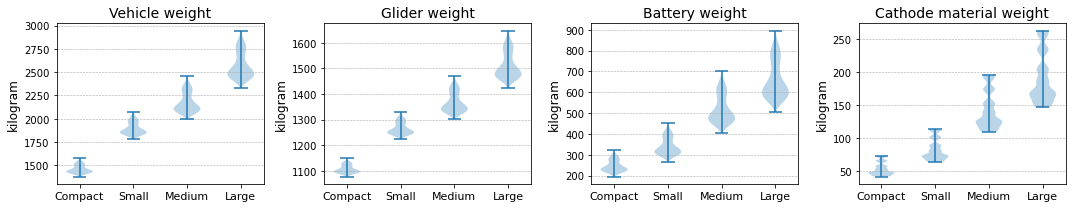

In [10]:
# Battery designs for each segment were calculated iteratively with the battery_design.py module
segments = {
    "Compact": range(0, int(len(D) / 4)),
    "Small": range(int(len(D) / 4), int(len(D) / 4) * 2),
    "Medium": range(int(len(D) / 4) * 2, int(len(D) / 4) * 3),
    "Large": range(int(len(D) / 4) * 3, int(len(D) / 4) * 4),
}


fig, ax = plt.subplots(1, 4, figsize=(15, 3))
vehicle_weight = {}
glider_weight = {}
battery_weight = {}
cam_weight = {}

for k, v in segments.items():
    vehicle_weight[k] = [bat_design_param_dct[x]["vehicle_weight"] for x in v]
    glider_weight[k] = [bat_design_param_dct[x]["glider_weight"] for x in v]
    battery_weight[k] = [bat_design_param_dct[x]["battery_system_weight"] for x in v]
    cam_weight[k] = [
        bat_design_param_dct[x]["positive_am_per_cell"] * bat_design_param_dct[x]["cells_per_pack"] / 1000 for x in v
    ]

ax[0].violinplot(vehicle_weight.values())
ax[0].set_title("Vehicle weight", fontsize=14)
ax[1].violinplot(glider_weight.values())
ax[1].set_title("Glider weight", fontsize=14)
ax[2].violinplot(battery_weight.values())
ax[2].set_title("Battery weight", fontsize=14)
ax[3].violinplot(cam_weight.values())
ax[3].set_title("Cathode material weight", fontsize=14)


for i, x in enumerate(ax.flatten()):
    x.yaxis.grid(True, linestyle="--", lw=0.6)
    x.set_xticks([y + 1 for y in range(len(segments.keys()))])
    x.set_xticklabels(segments.keys(), fontsize=11)
    x.set_ylabel("kilogram", fontsize=12)
fig.tight_layout()


and technical performance parameters (`3_PAR_battery_parameters`) such as pack level density:

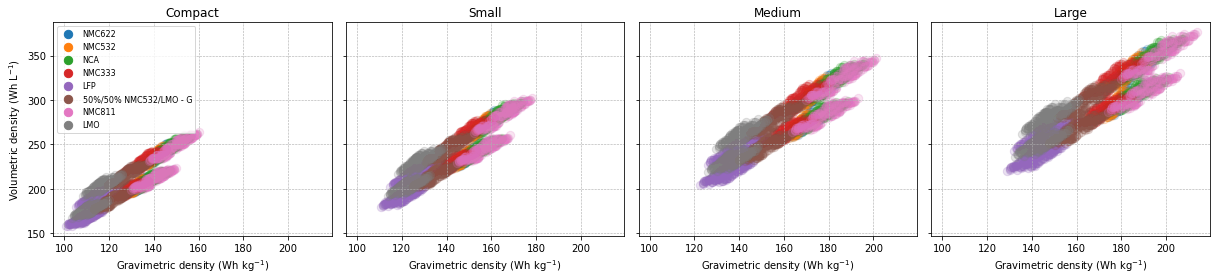

In [107]:
gr_density = {}
vol_density = {}
cam_choices =  set([bat_design_param_dct[x]["electrode_pair"] for x in D])

fig, ax = plt.subplots(1, 4, figsize=(17, 4), sharey=True, sharex=True)


for i, k in enumerate(segments.keys()):
    for idx, cathode in enumerate(cam_choices):

        gr_density[k] = [
            bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["battery_system_weight"] * 1000
            for x in segments[k] if bat_design_param_dct[x]["electrode_pair"] == cathode
        ]
        vol_density[k] = [
            bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["system_volume"] * 1000
            for x in segments[k] if bat_design_param_dct[x]["electrode_pair"] == cathode
        ]

        ax[i].scatter(gr_density[k], vol_density[k], alpha=0.1, color=cmap(idx),s=70, label=cathode.split(' (Energy')[0].split('-G')[0])
        ax[i].set_title(k)
        ax[i].set_xlabel(r"Gravimetric density (Wh kg$^{-1}$)", fontsize=10)
        ax[i].yaxis.grid(
            True,
            linestyle="--",
            lw=0.6,
        )
        ax[i].xaxis.grid(
            True,
            linestyle="--",
            lw=0.6,
        )
ax[0].set_ylabel(r"Volumetric density (Wh L$^{-1}$)", fontsize=10)
leg = ax[0].legend(fontsize=8)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.tight_layout()


A vehicle model was linked to BatPaC based on [Yelin et al., 2017](https://www.sciencedirect.com/science/article/abs/pii/S0378775317300368), whereby the battery weight and required battery energy are based on a desired vehicle range and segment specific vehicle characteristics.

For the case study the following input parameters where used for the vehicle model:

| parameter              | unit          | Compact | Small  | Medium | Large |
| ---------------------- | ------------- | ------- | ------ | ------ | ----- |
| rolling resistance     | N             | 101.86  | 110.59 | 136    | 209.4 |
| rotation resistance    | N/(m/s)       | 3.42    | -1.99  | 3.73   | 2.59  |
| aerodynamic resistance | N/(m/s)$^{2}$ | 0.37    | 0.46   | 0.41   | 0.47  |
| distance               | km            | 200     | 322    | 411    | 460   |
| auxiliary power        | W             | 475     | 575    | 715    | 775   |
| motor power            | kW            | 55      | 150    | 150    | 209   |


<br>

Comparing the modelled electricity consumption and vehicle weight with real values based on registration data from the European Environmental Agency illustrates that the modelled results match the real values:

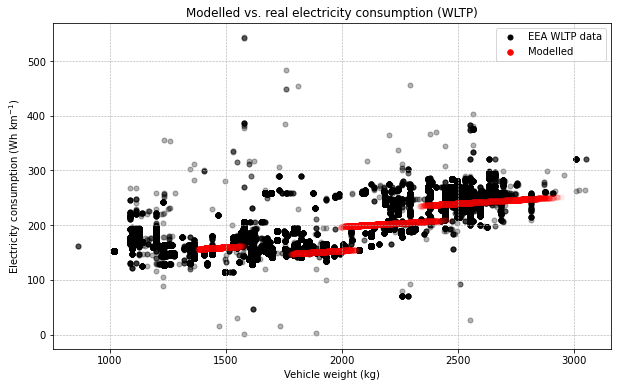

In [125]:
# Import prepared BEV registration data from the European Environmental Agency:
eea_2020 = pd.read_csv(".\data\\result_comparison\EEA_BEV_2020.gzip", compression="gzip", low_memory=False)
ener_cons_eea = eea_2020["z (Wh/km)"]
veh_mass = eea_2020["m (kg)"]

# Calculate vehicle electricity consumption from modelled data:
vehicle_weight = [bat_design_param_dct[x]["vehicle_weight"] for x in D]
ener_cons_modelled = [
    bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["Vehicle_range_km"] * 1000 for x in D
]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(veh_mass, ener_cons_eea, color="black", s=25, alpha=0.3, label="EEA WLTP data")
ax.scatter(vehicle_weight, ener_cons_modelled, color="r", s=30, alpha=0.03, label="Modelled")

ax.set_ylabel(r"Electricity consumption (Wh km$^{-1}$)")
ax.set_xlabel("Vehicle weight (kg)")
ax.set_title("Modelled vs. real electricity consumption (WLTP)")
ax.xaxis.grid(
    True,
    linestyle="--",
    lw=0.6,
)
ax.yaxis.grid(
    True,
    linestyle="--",
    lw=0.6,
)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)


And comparing the modelled result with real battery weights based on vehicles registered in 2017 and 2020 obtaind from a variety of sources:


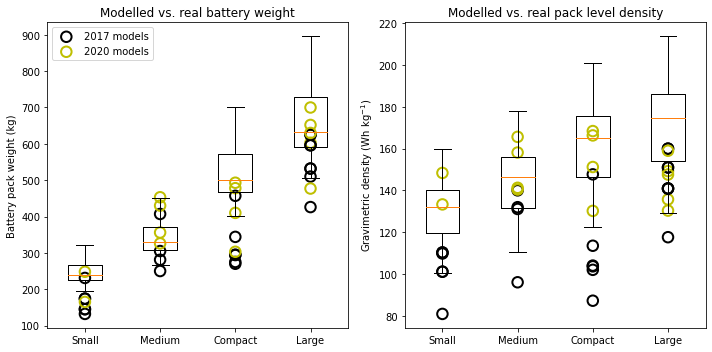

In [135]:
import string

# import battery weight data:
battery_wt_real = pd.read_excel(".\data\\result_comparison\pack_weight_2017_2020.xlsx", sheet_name="values")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

density_usable = {}
weight = {}
density_nominal = {}
for i, k in enumerate(segments.keys()):

    density_usable[k] = [
        bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["battery_system_weight"] * 1000 for x in segments[k]
    ]
    weight[k] = [bat_design_param_dct[x]["battery_system_weight"] for x in segments[k]]
ax[0].boxplot(weight.values())
ax[1].boxplot(density_usable.values())
for index, row in battery_wt_real.iterrows():
    x = string.ascii_lowercase.index(row["Segment"].lower())
    y = row["battery weight"]
    y1 = row["energy density"] * 1000
    if row["year"] == 2017:
        label = "2017 models"
        color = "k"
    else:
        label = "2020 models"
        color = "y"
    ax[1].scatter(x + 1, y1, color=color, label=label, s=110, facecolor="None", linewidth=2)
    ax[0].scatter(x + 1, y, color=color, label=label, s=110, facecolor="None", linewidth=2)
ax[0].set_xticklabels({"Compact", "Small", "Medium", "Large"})
ax[1].set_xticklabels({"Compact", "Small", "Medium", "Large"})

handles, labels = ax[0].get_legend_handles_labels()
lgd = dict(zip(labels, handles))
ax[0].legend(
    lgd.values(),
    lgd.keys(),
    fontsize=10,
    markerscale=1,
    loc="upper left",
)
ax[0].set_ylabel(r"Battery pack weight (kg)")
ax[0].set_title(r"Modelled vs. real battery weight")

ax[1].set_ylabel(r"Gravimetric density (Wh kg$^{-1}$)")
ax[1].set_title(r"Modelled vs. real pack level density")
fig.tight_layout()

The figure illustrates how battery density has improved over the year.<br> For example, based on the [EPA emissions testing application](https://dis.epa.gov/otaqpub/publist1.jsp), the VW E-golf in 2017 had a density of 103 wh/kg (36 kWh and battery weight 349 kg) as compared to 166 Wh/kg for the VW ID.4 (82 kWh and battery weight of 493).


# <b> Step 3.</b> foreground system modelling

The foreground system consists of all material and energy activity flows affected by the battery design choice:


<center><img src='../../docs/flow_map.png' width=1200/></center>



Due to the size constraints of Excel, the foreground matrix ($\bf{A}$) is not imported from the database but instead calculated. <br>

The calculation is based on process formula and parameters as established in Brightway


In [15]:
# Selecting process yield and energy consumption scenarios:

# energy
process_parameters = {
    param: process_yield
    for param, process_yield in zip(
        IndexTable.loc["Process_parameter", "Classification"].Items,
        ParameterDict["4_PY_battery_manufacturing"].Values[:, 0],  # default scenario is 0
    )
}
# energy consumption
process_parameters.update(
    {
        param: energy_consumption
        for param, energy_consumption in zip(
            IndexTable.loc["Process_parameter", "Classification"].Items,
            ParameterDict["4_PAR_energy_consumption"].Values[:, 1],  # default scenario is 1
        )
        if energy_consumption > 0
    }
)
process_parameters


# Import other default project parameters as used in Brightway
data_path_model = pkg_resources.resource_filename("batt_sust_model", "data/")


default_parameters = (
    pd.read_excel(data_path_model + "bw_default_project_parameters.xlsx", index_col=0).fillna(0).T.to_dict()
)


The foreground matrix for each battery design is calculated based on the defined process parameters and battery design parameters as solved with BatPaC. <br>


In [16]:
# Empty np array of size all pack design * materials * processes
A_matrix_nested = np.zeros((len(D), len(g), len(p)))

A_base = df_A_base.copy(deep=True)


# dictionary of the battery design parameters for all designs in non-alphanumeric parameters
param_dict_all = {}

# iterate over all pack designs and solve the process formulas based on specific pack parameters and process formulas:
for design in tqdm(D):
    param_dict_all[design] = bat_lca.parameter_dictionary(
        mc_battery_design_dct[design],
        process_parameters,
        bat_design_param_dct[design],
        default_parameters,
    )
    A_matrix_temp = bat_lca.calculate_modular_A(A_base, param_dict_all[design])

    A_matrix_nested[design] = A_matrix_temp


100%|██████████| 20736/20736 [01:51<00:00, 185.83it/s]


The result is a multi-dimensional numpy array containing all process input and outputs for all battery designs


In [29]:
A_matrix_nested.shape

(20736, 132, 146)

Using the ODYM index table the material flows for each battery design can be easy obtained. For example, all energy input for the production of battery design #30 can be obtained as follow:


In [62]:
energy = A_matrix_nested[ 30,:, [p.index(process) for process in bp]][:,[g.index("electricity for battery production, medium voltage"),g.index('heat, district or industrial, natural gas for battery production')]]

df_electr = pd.DataFrame(energy, index=bp, columns=["Electricity (kWh)", 'Natural gas (MJ)']).abs()
(df_electr[df_electr['Electricity (kWh)'] > 0].dropna().T.round(2).sort_values(by="Electricity (kWh)", axis=1)/33)

,mixing anode materials,final electrode drying,cathode slitting,anode slitting,mixing cathode materials,anode coating and drying,cell stacking,cathode calendering,anode calendering,cathode coating and drying,electrolyte filling and sealing,module and pack assembly,cell formation
Electricity (kWh),0.024242,0.033030,0.042121,0.042121,0.044848,0.116970,0.127879,0.155455,0.155455,0.370909,2.645455,2.699091,7.152121
Natural gas (MJ),0.000000,3.353333,0.000000,0.000000,0.000000,4.713333,0.000000,0.000000,0.000000,14.925455,17.632424,0.000000,1.223636


# <b>STEP 4.</b> Calculate satellite accounts

Satellite accounts are linked to the identified impact indicators and calculated using different analytical methods. In this case study, four satellite accounts are included and calculated with the following methods:


| Impact indicator              | Satellite account (notation) | Unit        | Calculation method | 
| ---------------------- | ------------- | ------- | --|
| Carbon footprint     | Global warming potential ($\mathbf{h}$)      | kg CO<sub>2</sub> eq.      | Life cycle impact assessment  |
| Battery cost   | Value added    ($\mathbf{v}$)     | US$ |Life cycle costing    | 
| Material criticality | Substance flows ($\mathbf{E}$)   and value added ($\mathbf{v}$)   |kg & US$ |Substance flow analysis and life cycle costing   | 
| Technical performance | Pack level gravimetric energy density ($\mathbf{p}$)  | Wh<sub>usable</sub> kg<sup>-1</sup>|Technical performance model (BatPaC)   |




## Global warming potential ($\mathbf{h}$)


CHANGE THISThe carbon footprint layer refers to all life cycle carbon emissions and is calculated based on the modular LCA approach (Steubing et al., 2016). The total environmental impact ($h$) can be obtained by multiplying the pre-calculated process emissions ($\mathbf{h_{base}}$) with the scaling vector ($\mathbf{s}$) :

$$h = \mathbf{h_{base}}\times \mathbf{s}$$

To calculate the impacts of all battery designs, the scaling vector is obtained with the matrix based LCA calculation (Heijungs & Suh, 2002):

$$\mathbf{s} = \mathbf{A}^{-1}\mathbf{f}$$

The base moduxx

In [72]:
# The imported modular h base contains all ReCiPe impact indictors, in this study we only select GWP
impact_cat = 2  # GWP100

# Empty nested array of size battery_designs  X foreground_processes:
h_nested = np.zeros([len(D), len(p)])

In [ ]:
H_nested_square = np.einsum('ij, j -> ij', s_nested, H_base[impact_cat, process_selection])

In [19]:
# First, the relevant production needs to be selected to asssure the A and h matrices are square
country = "European average"

electricity_choice = f"market group for electricity battery production, medium voltage, {country}"
gas_choice = f"market group for heat, district or industrial, natural gas, {country}"

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))




# Empty np array # Empty nested np array where the first element refers to all battery designs and the second to the process emissions the nested scaling vector:
s_nested =  np.zeros([len(D), len(process_selection)])

# Calculate process emissions for each battery design using the formulas described above:
for design in tqdm(D):
    # specific pack weight as function unit:
    fu = A_matrix_nested[design, g.index("battery pack"), p.index("module and pack assembly")]
    # Inverse the A matrix:
    A_inv = np.linalg.pinv(A_matrix_nested[design, :, process_selection].T)
    # Establish final product demand vector for 1 battery based on pack weight
    y = np.zeros(len(g))
    y[g.index("battery pack")] = fu
    # Obtain the scaling vector
    s_nested[design] =  A_inv.dot(y)



100%|██████████| 20736/20736 [01:08<00:00, 303.57it/s]


In [20]:
# pd.DataFrame(s_nested, D, [p[x] for x in process_selection]).to_excel(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\paper\Third paper\Figures_code\Figures data\df_s.xlsx')

KeyboardInterrupt: 

Calculate the emissions for each pack using np.einsum:

## Value added layer ($\mathbf{v}$)

The value added layer is calculated in two steps: the factor ($\bf{F}$) and material cost ($\bf{C}$). <br> Click [here](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20cost/Example%20notebook%20battery%20cost.ipynb) for a more detailed example notebook of the battery cost calculation. 

### Battery production factor cost ($\mathbf{F}$)

First, the value added for battery production ($\mathbf{v}_{bat}$) is calculated based on the primary production factor requirements, including building/land, labour and capital requirement. This is calculated by multiplying the physical factor matrix ($\mathbf{F'}$) and a vector of factor cost ($\mathbf{\pi}$) as described by Duchin and Levin (2011):
$$\mathbf{v}_{bat}= \mathbf{F}_{bat}\mathbf{\pi}$$

The battery production process factor requirement is calculated with the battery_cost.py script and the `factors_battery_production` formula. The underlying calculations are based on BatPaC and account for the manufacturing output scale. 


In [ ]:
importlib.reload(bat_cost)

<module 'batt_sust_model.battery_cost' from 'C:\\Users\\Joris\\OneDrive - Newcastle University\\Python\\Projects\\Bat_Sust_Model\\batt_sust_model\\battery_cost.py'>

In [ ]:
# Default BatPaC capacity of 500,000 packs per year is used:
manufacturing_capacity = 500000

# Change the capacity parameter for all battery designs
for x in param_dict_all.keys():
    param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity

# Returns the nested F matrix with factors (rows) for all battery production processes (columns)
F_physical_nested_temp = bat_cost.factors_battery_production(param_dict_all, run_multiple=True, return_index=f, return_columns=bp)

# Include all foreground processes:
F_physical_nested = np.zeros([len(D), len(f), len(p)])

F_physical_nested[:, :, [p.index(process) for process in set(bat_cost.process_mapping.values())]] = F_physical_nested_temp

The physical factor requirements (land and labour) are multiplied with the factor prices ($\pi$) to obtain the monetary factor requirements. <br>

The price factors are country specific. Capital is multiplied by 1,000,000 to convert from million $


In [ ]:
df_factor_cost = pd.DataFrame(ParameterDict["3_PR_factor_price"].Values, index=f, columns=r).round(2)
df_factor_cost.insert(0, "Unit", ["$/m2", "$/hr", "$/$"])
df_factor_cost

,Unit,FR,DE,HU,NO,PL,SE,GB,European average
land,$/m2,2380.08,2213.95,1219.94,3683.20,1503.39,3074.60,2291.40,2338.08
labour,$/hr,43.25,42.18,11.73,59.48,12.68,43.25,33.77,35.19
capital,$/$,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00


Operating expenses (e.g. R&D investments and depreciation rates) are allocated to the factor cost based on the multipliers for overhead to basic cost calculation as used in BatPaC.



In [ ]:
bat_cost.factor_overhead_multiplier(return_index=f)

{'land': 0.153252, 'labour': 1.8664800000000001, 'capital': 0.253704}

Multiplying physical factor matrix by the region specific factor prices using np.einsum to establish the monetary factor matrix:


In [ ]:
factor_cost = ParameterDict["3_PR_factor_price"].Values[
        :, IndexTable.loc["Regions", "Classification"].Items.index(country)
    ]
factor_cost

F_monetary_nested = np.einsum('dfp, f -> dfp', F_physical_nested, (factor_cost*list(bat_cost.factor_overhead_multiplier(return_index=f).values())))
#divided by the manufacturing capacity to obtain the factor cost per pack:
F_monetary_nested = F_monetary_nested/manufacturing_capacity


The resulting matrix represents the value added in terms of land, labour and capital requirement for each battery production process. <br>

For battery design 30 for example, the value added for each process and 1 produced battery is:


### Battery material cost ($\mathbf{C}$)

The second step of the value added layer are the value added calculation outside the battery factory. This refers to the material cost ($\mathbf{C}$) and is based on the computational structure of life cycle cost as proposed by Heijungs et al. (2012) and Moreau and Weidema (2015) to obain the monetary equivalant of the technology matrix:

$$\mathbf{C} = \mathbf{A}\mathbf{\alpha}$$

<br>

The general material cost can obtained from the technology matrix ($\mathbf{A}$) and the material cost vector ($\mathbf{\alpha}$).

The material cost vector consist the mass prices ($\mathbf{\alpha_{mass}}$) obtained from a variety of sources:


In [ ]:
df_pr_material_mass = pd.Series(ParameterDict["3_PR_material_price_mass"].Values, g)
pd.DataFrame(df_pr_material_mass[df_pr_material_mass > 0], columns=["$/kg"]).head(10)


,$/kg
anode active material (natural graphite),9.10020
anode active material (SiO),60.00000
anode active material (synthetic graphite),12.15972
anode binder (CMC),5.00000
anode binder additive (SBR),5.00000
anode carbon black,3.60000
anode current collector Cu (10um),15.43505
anode current collector Cu (11um),15.43505
anode current collector Cu (12um),15.43505
anode current collector Cu (13um),15.43505


And unit prices ($\mathbf{\alpha_{unit}}$) obtained from BatPaC. <br>

The cell container for example, is calculated based on a mass price and the total cells per pack:


In [ ]:
df_pr_unit = pd.DataFrame(ParameterDict["3_PR_material_price_unit"].Values, g, P)
df_pr_unit = df_pr_unit[(df_pr_unit != 0).any(axis=1)]
df_pr_unit.loc["cell container"].sort_values()

electrode_pair             0.0
calculate_fast_charge      0.0
max_charging_time          0.0
available_energy           0.0
vehicle_weight             0.0
                          ... 
negative_electrode_area    0.0
positive_electrode_area    0.0
total_packs_vehicle        0.0
pack_energy                0.0
cells_per_pack             0.2
Name: cell container, Length: 79, dtype: float64

In [ ]:
# Restructure unit prices to dictionary:
dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2


In [ ]:
C_matrix_nested = np.load(r'C:\Users\Joris\Desktop\C_matrix_nested.npy')

In [ ]:
# Empty C matrix
C_matrix_nested = np.zeros((len(D), len(g), len(p)))


C_matrix_nested = bat_cost.material_cost_matrix(
    A_matrix_nested,
    df_pr_material_mass,
    dict_pr_unit,
    system_design_parameters=param_dict_all,
    run_multiple=True,
    process_columns=p,
    material_rows=g,
)


In [ ]:
# Include energy cost for all regions:
for region in r:
    electricity_price = ParameterDict["3_PR_regional_energy_price"].Values[0, r.index(region)]
    gas_price = ParameterDict["3_PR_regional_energy_price"].Values[1, r.index(region)]
    C_matrix_nested[
        :,
        g.index("electricity for battery production, medium voltage"),
        p.index(f"market group for electricity battery production, medium voltage, {region}"),
    ] = electricity_price
    C_matrix_nested[
        :,
        g.index("heat, district or industrial, natural gas for battery production"),
        p.index(f"market group for heat, district or industrial, natural gas, {region}"),
    ] = gas_price


### Total value added ($\mathbf{v}$) layer


In [ ]:
# Non scaled added value vector:
# process value added based on factor requirements:
v_nested = np.sum(F_monetary_nested, 1)
# material process value added based on C matrix:
v_nested[:] += np.sum(C_matrix_nested, 1)


## Substance flow layer ($\mathbf{E}$)

The substance flow matrix ($\mathbf{E}$) is calculated by multiplying the technology matrix with the elemental content of goods. <br>

For example, 1kg of NMC333 cathode active material contains the following elements:


In [ ]:
pd.DataFrame(ParameterDict["3_MC_element_goods"].Values, e, g).loc[:, "cathode active material (NMC333)"].to_frame()

,cathode active material (NMC333)
All,0.000000
Li,0.077618
Al,0.000000
Si,0.000000
P,0.000000
Mn,0.185128
Fe,0.000000
Co,0.198572
Ni,0.197831
Cu,0.000000


In [ ]:
pd.DataFrame(ParameterDict["3_MC_element_goods"].Values, e, g)[[x for x in g if 'cathode active material' in x]].loc['Li']

cathode active material (LFP)                      0.043991
cathode active material (LMO)                      0.043370
cathode active material (NCA)                      0.072219
cathode active material (NMC333)                   0.077618
cathode active material (NMC532)                   0.077497
cathode active material (50%/50% NMC532/LMO - )    0.040846
cathode active material (NMC622)                   0.077203
cathode active material (NMC811)                   0.076929
Name: Li, dtype: float64

In [ ]:
E_matrix_nested = np.einsum ('ijk, ej -> iek', A_matrix_nested,ParameterDict["3_MC_element_goods"].Values )

For example, the total substance demand to produce one battery pack (design #30) are:

In [ ]:
print (' Battery size:', int(param_dict_all[30]['pack_energy_kWh']), 'kWh\n',
       'Cathode chemistry: ', param_dict_all[30]['electrode_pair'] )

df_temp = pd.DataFrame(np.sum(E_matrix_nested[30, :, [p.index(x) for x in bp]], 0).round(2), e, columns= ['Design 30']).abs()
df_temp['unit'] = 'kg'
df_temp

 Battery size: 33 kWh
 Cathode chemistry:  LFP-G (Energy)


,Design 30,unit
All,0.00,kg
Li,3.40,kg
Al,16.68,kg
Si,0.00,kg
P,14.69,kg
Mn,0.00,kg
Fe,75.48,kg
Co,0.00,kg
Ni,0.00,kg
Cu,23.75,kg


# <b> STEP 5.</b> Solution & visualisation
 Calculate results for all designs:


Solving all designs:

In [ ]:
# First, the relevant production needs to be selected to asssure the A and h matrices are square
country = "European average"

electricity_choice = f"market group for electricity battery production, medium voltage, {country}"
gas_choice = f"market group for heat, district or industrial, natural gas, {country}"

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))

p_selection_name = [p[i] for i in process_selection]


In [ ]:
E_matrix_nested[0, e.index('Cu'), [p.index(x) for x in bp]]

array([-8.77513249,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -2.67195473,  0.        , -6.0566585 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [ ]:
# pd.DataFrame(mc_battery_designs, D, g).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\material_content.csv")

In [ ]:
# Empty np array # Empty nested np array where the first element refers to all battery designs and the second to the process emissions the nested scaling vector:
s_nested =  np.zeros([len(D), len(process_selection)])

# Calculate process emissions for each battery design using the formulas described above:
for design in tqdm(D):
    # specific pack weight as function unit:
    fu = A_matrix_nested[design, g.index("battery pack"), p.index("module and pack assembly")]
    # Inverse the A matrix:
    A_inv = np.linalg.pinv(A_matrix_nested[design, :, process_selection].T)
    # Establish final product demand vector for 1 battery based on pack weight
    y = np.zeros(len(g))
    y[g.index("battery pack")] = fu
    # Obtain the scaling vector
    s_nested[design] =  A_inv.dot(y)



In [ ]:
# The imported modular h base contains all ReCiPe impact indictors, in this study we only select GWP
impact_cat = 2  # GWP100

# Multiply all layers by the scaling vector
h_nested_scaled = np.einsum("ij, j -> ij", s_nested, H_base[impact_cat, process_selection])
v_nested_scaled = np.einsum("ij, ij -> ij", s_nested, v_nested[:, process_selection])
E_nested_scaled = np.einsum("ij, iej -> iej", s_nested, E_matrix_nested[:, :, process_selection])



In [ ]:
# pd.DataFrame(C_scaled, D, p_selection).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_materials.csv")
# # pd.DataFrame(F_monetary_nested.sum(axis=2), D, f).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_factors.csv")
# # pd.DataFrame(v_nested_scaled, D, p_selection).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_cost.csv")
# # pd.DataFrame(h_nested_scaled, D, p_selection).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\process_emissions_all_pack_design.csv")
# pd.DataFrame(c_nested_scaled, D, e).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_criticality.csv")

Material criticality (c) is calculated by multiplying the economic product importance (EPI) with the supply disruption probability (SPD).:

$$ c = \sum_{e} EPI_e \times SDP_e $$

where the EPI is based on the 

\begin{equation}
\mathbf{EPI}_{e} =\frac{ \mathbf{\Omega}_e \times \mathbf{E}_{e, bp}\times -1}{v}
\end{equation}

\begin{equation}
\mathbf{SDP}_{e, p} =\mathbf{E}_{e,bp}\times-1\odot \mathbf{ESSENZ}_{e}
\end{equation}




In [ ]:
df_mineral_price = pd.DataFrame(
    ParameterDict["3_PR_mineral_price"].Values, e, IndexTable.loc["Sensitivity_analysis", "Classification"].Items
)
df_ESSENZ = pd.DataFrame(ParameterDict["6_CR_ESSENZ_CF_elements"].Values, e)

battery_production_index = [p_selection_name.index(i) for i in bp]


EPI_scaled = np.zeros((len(D), len(e)))
SC_scaled = np.zeros((len(D), len(e)))

for design in D:
    EPI_scaled[design] = (
        (df_mineral_price["used"].values * E_nested_scaled[design, :, battery_production_index]).sum(axis=0)
        / v_nested_scaled[design].sum()
        * -1
    )
    SC_scaled[design] = (
        E_nested_scaled[design, :, battery_production_index].T * ParameterDict["6_CR_ESSENZ_CF_elements"].Values
    ).sum(axis=1) * -1

c_nested_scaled = EPI_scaled * SC_scaled


In [ ]:
# np.save(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\SC_scaled.npy", SC_scaled)


In [ ]:
w = [param_dict_all[x]['battery_pack'] for x in D]

In [ ]:
w.index(max(w))

18127

In [ ]:
max(w)

896.0683808489813

In [ ]:
param_dict_all[18127]

{'aluminium_wrought_alloy': 0.0,
 'anode_active_material_natural_graphite': 0.0,
 'anode_active_material_sio': 0.0,
 'anode_active_material_synthetic_graphite': 116.9347674984982,
 'anode_binder_cmc': 1.431854295899973,
 'anode_binder_additive_sbr': 0.954569530599982,
 'anode_carbon_black': 0.0,
 'anode_current_collector_cu_10um': 0.0,
 'anode_current_collector_cu_11um': 0.0,
 'anode_current_collector_cu_12um': 0.0,
 'anode_current_collector_cu_13um': 0.0,
 'anode_current_collector_cu_14um': 101.4297483882017,
 'anode_current_collector_cu_6um': 0.0,
 'anode_current_collector_cu_7um': 0.0,
 'anode_current_collector_cu_8um': 0.0,
 'anode_current_collector_cu_9um': 0.0,
 'anode_electrode_scrap': 0.0,
 'anode_slurry': 199.64649789650284,
 'battery_jacket': 124.2188399452158,
 'battery_jacket_al': 47.68466374211195,
 'battery_jacket_insulation': 2.602819207599065,
 'battery_jacket_fe': 73.93135699550476,
 'battery_management_system': 3.5776,
 'battery_pack': 896.0683808489813,
 'battery_pro

In [ ]:
# Performance:
p_nested = [
    bat_design_param_dct[design]["pack_usable_energy_kWh"] / bat_design_param_dct[design]["battery_system_weight"] * 1000 for design in D
]


Overview of the carbon footprint for all 20,736 design options results by cathode chemistry on the pack, energy and kg level:


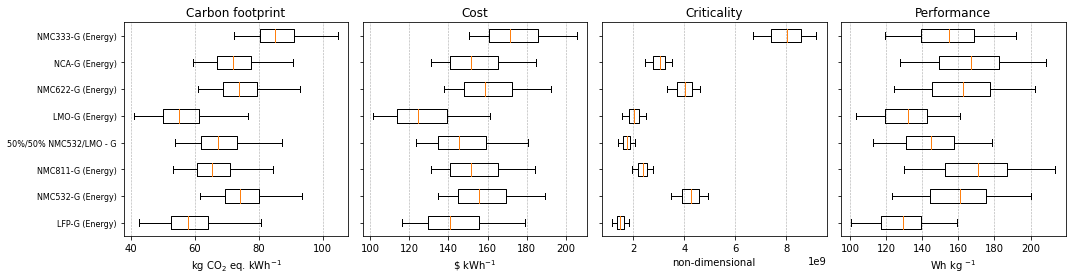

In [ ]:
colour = []

cathode_by_design = {design: bat_design_param_dct[design]["electrode_pair"] for design in D}
all_cathodes = set(cathode_by_design.values())

impacts_all = {
    "Carbon footprint": h_nested_scaled,
    "Cost": v_nested_scaled,
    "Criticality": c_nested_scaled,
    "Performance": p_nested,
}

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for idx, impact in enumerate(impacts_all.keys()):
    if impact != "Performance":
        impacts = {
            design: impacts_all[impact][design].sum() / bat_design_param_dct[design]["pack_energy_kWh"] for design in D
        }
    else:
        impacts = impacts_all[impact]
    y_values = {}
    for cathode in all_cathodes:
        y_values[cathode] = [impacts[x] for x in cathode_by_design.keys() if cathode_by_design[x] == cathode]
    ax[idx].boxplot(y_values.values(), vert=False)
    ax[idx].set_title(impact)
    ax[idx].xaxis.grid(
        True,
        linestyle="--",
        lw=0.6,
    )
    ax[idx].set_yticklabels([])
ax[0].set_xlabel(r"kg CO$_2$ eq. kWh$^{-1}$")
ax[1].set_xlabel(r"\$ kWh$^{-1}$")
ax[2].set_xlabel(r"non-dimensional")
ax[3].set_xlabel(r"Wh kg $^{-1}$")


ax[0].set_yticklabels(all_cathodes, fontsize=8, rotation=0)

fig.tight_layout()


# Calculate optimal design (multi-objective optimisation)


Next we use multi-objective optimisation to find the optimal design configurations.

The first step is to convert the nested matrices to square matrices. 

In [ ]:
segment_choice = range(int(len(D) / 4) * 2, int(len(D) / 4) * 4)
segment_choice

range(10368, 20736)

In [ ]:
# As the 
segment_choice = range(int(len(D) / 4) * 2, int(len(D) / 4) * 4)
segment_choice = 'test'
impact_category = 2  # GWP
country_selection = "European average"

# All goods minus internal goods:
g_new = [i for i in g if i not in IndexTable.loc["Internal_goods", "Classification"].Items]

# All processes minus production:
# Exclude material handling from 'internal process'
# internal_process = [
#     process for process in bp if process != "material handling" and process != "wastewater, average"
# ]  # REMOVED THIS LINE:

# New battery process names based on design
p_new = []
if segment_choice == "test":
    segment_choice = list(range(0, 5))
    for d in segment_choice:
        p_new.append(d)
else:
    for d in segment_choice:
        p_new.append(d)
# New process list, material handling must be included for mass balance

for x in p:
    if x == 'building and supporting systems':
        p_new.append(x)
    if x in bp:
        continue
    p_new.append(x)


# Select only regional electricity and gas
for country in r:
    if country != country_selection:
        p_new.pop(p_new.index(f"market group for electricity battery production, medium voltage, {country}"))
        p_new.pop(p_new.index(f"market group for heat, district or industrial, natural gas, {country}"))

# Empty A matrix:
A_matrix = np.zeros((len(g_new), len(p_new)))

batt_manuf_index = [p.index(x) for x in bp]
# Exclude material handling to include waste:
# batt_manuf_index.pop(batt_manuf_index.index(p.index("material handling")))


# Sum battery production input for each design
g_select = [g.index(x) for x in g if x not in IndexTable.loc["Internal_goods", "Classification"].Items]
for idx, battery_model in enumerate(segment_choice):
    A_matrix[:, idx] = A_matrix_nested[battery_model, :, batt_manuf_index].T[g_select].sum(axis=1)

# Include base module values to A matrix
for process in [x for x in p if x not in D and x not in bp]:
    # if process == 'material handling':
    #     continue
    if "electricity" in process or "natural gas" in process:
        continue
    A_matrix[:, p_new.index(process),] = ParameterDict[
        "4_UPI_foreground_base"
    ].Values[g_select, p.index(process)]


# Include regional energy:

electricity_production = f"market group for electricity battery production, medium voltage, {country}"
gas_production = f"market group for heat, district or industrial, natural gas, {country}"
A_matrix[:, p_new.index(electricity_production)] = ParameterDict["4_UPI_foreground_base"].Values[
    g_select, p.index(electricity_production)
]
A_matrix[:, p_new.index(gas_production)] = ParameterDict["4_UPI_foreground_base"].Values[
    g_select, p.index(gas_production)
]

# Include production scrap:
A_matrix[g_new.index("battery production scrap"), p_new.index('building and supporting systems')] = -1

A_matrix = A_matrix.round(5)


In [ ]:
p

['anode active material (natural graphite) import',
 'anode active material (SiO) import',
 'anode active material (synthetic graphite) import',
 'anode binder (CMC) production',
 'anode binder additive (SBR) production',
 'anode calendering',
 'anode coating and drying',
 'anode current collector Cu (10um) production',
 'anode current collector Cu (11um) production',
 'anode current collector Cu (12um) production',
 'anode current collector Cu (13um) production',
 'anode current collector Cu (14um) production',
 'anode current collector Cu (6um) production',
 'anode current collector Cu (7um) production',
 'anode current collector Cu (8um) production',
 'anode current collector Cu (9um) production',
 'anode electrode scrap handling',
 'anode slitting',
 'battery jacket aluminium',
 'battery jacket insulation',
 'battery jacket production',
 'battery jacket steel',
 'battery management system production',
 'binder solvent (deionised water) market',
 'busbar production',
 'carbon black 

In [ ]:
emission_layer = np.zeros(len(p_new))
criticality_layer = np.zeros((len(p_new), len(e)))
impact_category = 2  # GWP100

# for x in p_new[len(segment_choice):len(p_new)]:
#     emission_layer [p_new.index(x)] = H_base [impact_category, p.index(x)]


p_new_external = [x for x in p_new if x not in segment_choice]

performance_layer = np.zeros(len(p_new))

performance_layer[range(len(segment_choice))] = [
    bat_design_param_dct[design]["pack_usable_energy_kWh"] / mc_battery_design_dct[design]["battery pack"] * 1000
    for design in segment_choice
]


value_added_layer = np.zeros(len(p_new))
substance_layer = np.zeros((len(e), len(p_new)))

for idx, battery_model in enumerate(segment_choice):
    # value_added_layer[idx] = B_matrix_nested[battery_model, batt_manuf_index].sum()
    value_added_layer[idx] = v_nested_scaled[battery_model].sum()
    # F_monetary_nested[r.index(country_selection),battery_model, ].sum() + C_matrix_nested[battery_model, :,batt_manuf_index ].T[g_select].sum()
    # value_added_layer [idx] =
    # substance_layer[:,idx] =  E_matrix_nested[battery_model, 0, :, batt_manuf_index].sum(axis=0)
    criticality_layer[idx] = SC_scaled[battery_model] * EPI_scaled[battery_model]
    emission_layer[idx] = H_nested_square[battery_model, 0].sum()



Pyomo model

In [ ]:
np.sum(A_matrix >= 0, axis=0)


array([ 80,  80,  79,  79,  79, 117, 117, 116, 117, 116, 115, 115, 115,
       115, 115, 115, 115, 115, 115, 116, 116, 110, 116, 116, 117, 115,
       114, 116, 115, 115, 115, 115, 117, 115, 115, 117, 117, 115, 115,
       115, 115, 115, 115, 115, 115, 115, 113, 115, 115, 115, 115, 115,
       115, 116, 117, 116, 115, 115, 117, 117, 117, 117, 117, 117, 114,
       114, 114, 117, 114, 114, 114, 114, 115, 114, 115, 115, 115, 117,
       116, 117, 117, 117, 115, 117, 116, 115, 115, 115, 115, 115, 115,
       114, 114, 114, 114, 115, 115, 116, 116, 116, 117, 117, 117, 117,
       117, 116, 117, 116, 117, 117])

In [ ]:
missing  =[]
for row in range(0,A_matrix.shape[1]):
    if np.any(A_matrix[row] == 1) == False:
        print (g_new[row])
        missing.append(row)
    

anode electrode scrap
battery production scrap
cathode binder solvent waste
cathode electrode scrap
cell scrap
electrolyte scrap
separator (11um)
separator (13um)
separator (15um)
separator (17um)
separator (19um)
separator scrap


In [ ]:
g_new[16]

'anode electrode scrap'

In [ ]:
A_matrix = A_matrix.round(2)

# scenarios:
criticality_list = ["Li", "P", "Mn", "Co", "Ni"]
elements = IndexTable.loc["Elements", "Classification"].Items
model = pyo.ConcreteModel("battery_design_model")
CF_essenz = ParameterDict["6_CR_ESSENZ_CF_elements"].Values


# Set battery pack to 1 unit:
A_matrix[g_new.index("battery pack"), 0 : len(segment_choice)] = 1


# waste = IndexTable.loc['Waste', 'Classification'].Items
goods = [good for good in g_new if good != "battery production scrap"]

# final demand vector; 100000 battery pack:
y = {x: 0 for x in g_new}
y["battery pack"] = 1
model.y = pyo.Param(g_new, initialize=y, mutable=False)

model.epsilon = pyo.Param(initialize=1000000, mutable=True)

# Supply vector:
model.x = pyo.Var(p_new, domain=pyo.NonNegativeReals)

# Change battery production processes to integers (only 1 whole battery can be produced.. )
for process in segment_choice:
    model.x[process].domain = pyo.NonNegativeIntegers

# Objective functions, written as variables for MOO:
model.performance = pyo.Var()
model.gwp = pyo.Var()

model.criticality = pyo.Var()
model.cost = pyo.Var()


model.C_performance = pyo.Constraint(
    expr=model.performance == sum(model.x[process] * performance_layer[p_new.index(process)] for process in p_new)
)

model.C_criticality = pyo.Constraint(
    expr=model.criticality
    == sum(
        model.x[process] * criticality_layer[p_new.index(process), element]
        for process in p_new
        for element in range(len(e))
    )
)

model.C_cost = pyo.Constraint(
    expr=model.cost == sum(model.x[process] * value_added_layer[p_new.index(process)] for process in p_new)
)
model.C_gwp = pyo.Constraint(
    expr=model.gwp == sum(model.x[process] * emission_layer[p_new.index(process)] for process in p_new)
)

model.O_gwp = pyo.Objective(expr=model.gwp, sense=pyo.minimize)
model.O_cost = pyo.Objective(expr=model.cost, sense=pyo.minimize)

model.O_performance = pyo.Objective(expr=model.performance, sense=pyo.maximize)
model.O_criticality = pyo.Objective(expr=model.criticality, sense=pyo.minimize)

# model.production_constraint = pyo.Constraint(expr=model[x]


def material_balance(model, good):
    """Mass balance and demand constraint"""
    mb = sum(model.x[process] * A_matrix[g_new.index(good), p_new.index(process)] for process in p_new) == model.y[good]
    if mb is True:
        return pyo.Constraint.Skip
    return mb


def material_balance_waste(model, waste):
    """Mass balance and demand constraint"""
    mb = (
        sum(model.x[process] * A_matrix[g_new.index(waste), p_new.index(process)] for process in p_new)
        >= model.y[waste]
    )
    if mb is True:
        return pyo.Constraint.Skip
    return mb


model.material_balance = pyo.Constraint(goods, rule=material_balance)
model.material_balance_waste = pyo.Constraint(["battery production scrap"], rule=material_balance_waste)

size_constraint_segments = {
    "length": {199: 1250, 322: 1700, 410: 1900, 459: 2000},
    "width": {199: 1053, 322: 1200, 410: 1250, 459: 1300},
    "height": {199: 160, 322: 160, 410: 160, 459: 160},
}


def pack_length_constraint(model, process, size_constraint=size_constraint_segments):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_length"] <= size_constraint["length"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip


def pack_width_constraint(model, process, size_constraint=size_constraint_segments):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_width"] <= size_constraint["width"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip


def pack_height_constraint(model, process, size_constraint=size_constraint_segments):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_height"] <= size_constraint["height"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip


model.pack_length_constraint = pyo.Constraint(p_new, rule=pack_length_constraint)
model.pack_width_constraint = pyo.Constraint(p_new, rule=pack_width_constraint)
model.pack_height_constraint = pyo.Constraint(p_new, rule=pack_height_constraint)


In [ ]:
model.material_balance_waste.pprint()

material_balance_waste : Size=1, Index=material_balance_waste_index, Active=True
    Key                      : Lower : Body                                                      : Upper : Active
    battery production scrap :   0.0 : 0.15*x[0] + 0.15*x[1] + 0.15*x[2] + 0.15*x[3] + 0.15*x[4] :  +Inf :   True


Iterate over objective functions:

In [ ]:
# Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

# deactivate all:
[objective.deactivate() for objective in objectives]

df = pd.DataFrame(
    index=[
        "Cost",
        "Carbon footprint",
        "Performance",
        "Criticality",
        "Pack design",
        "Pack weight",
        "Vehicle weight",
        "Pack capacity",
        "Vehicle segment",
        "Cathode chemistry",
        "Graphite",
        "Separator",
        "Separator coating",
        "Cell thickness",
        "Silicon additive",
        "Cathode foil",
        "Anode foil",
    ]
)
df["Unit"] = [
    "$",
    "CO\N{SUBSCRIPT TWO}-eq.",
    "Wh kg\N{SUPERSCRIPT ONE}",
    "kg",
    "Category",
    "kg",
    "kg",
    "kWh",
    "Segment",
    "Category",
    "Category",
    "um",
    "um",
    "cm",
    "wt%",
    "um",
    "um",
]

# Iterate through all:
for objective in objectives:
    objective.activate()
    print(f"Solving {objective.name}")
    pyo.SolverFactory("cplex").solve(model, logfile="some_file_name.log")
    for process in p_new:
        if model.x[process].value > 0 and process in segment_choice:
            design = process

    df[objective.name] = [
        round(pyo.value(model.cost), 2),
        round(pyo.value(model.gwp), 2),
        round(pyo.value(model.performance), 2),
        round(pyo.value(model.criticality), 2),
        design,
        round(bat_design_param_dct[design]["battery_system_weight"], 1),
        round(bat_design_param_dct[design]["vehicle_weight"], 0),
        round(bat_design_param_dct[design]["pack_energy_kWh"], 3),
        0,
        bat_design_param_dct[design]["electrode_pair"],
        bat_design_param_dct[design]["graphite_type"],
        bat_design_param_dct[design]["sep_foil_thickness"],
        bat_design_param_dct[design]["sep_coat_thickness"],
        bat_design_param_dct[design]["cell_thickness_target"],
        bat_design_param_dct[design]["silicon_anode"],
        bat_design_param_dct[design]["positive_foil_thickness"],
        bat_design_param_dct[design]["negative_foil_thickness"],
    ]
    objective.deactivate()

df


Solving O_gwp


TypeError: '>' not supported between instances of 'NoneType' and 'int'

## Epsilon constraint

In [ ]:
try:
    del model.eq2
except:
    pass 
obj_1 = model.cost
obj_2 = model.performance

model.eq2= pyo.Constraint(expr= obj_1<=model.epsilon)


#Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

#deactivate all:
[objective.deactivate() for objective in objectives]


model.O_cost.activate()

solver = pyo.SolverFactory('cplex')  
solver.solve(model)

maxOF1 = pyo.value(obj_2)
minOF2 = pyo.value(obj_1)
print ('optimizing for obj1:')
print('obj2 = ' + str(pyo.value(obj_2)))
print('obj1 = ' + str(pyo.value(obj_1)))
model.O_cost.deactivate()


model.O_performance.activate()

solver.solve(model)

minOF1 = pyo.value(obj_2)
maxOF2 = pyo.value(obj_1)
print ('optimizing for obj2:')

print('obj2 = ' + str(pyo.value(obj_2)))
print('obj1 = ' + str(pyo.value(obj_1)))
model.O_performance.deactivate()

In [ ]:
model.O_performance.activate()

Nsteps= 3
X=[]
Y=[]
design_choice = []
print('   OBJ1 ',' OBJ2 ',' Epsilon ')
p_values = []
for counter in range(1,Nsteps+1):
    model.epsilon=minOF2+(maxOF2-minOF2)*(counter-1)/(Nsteps-1)
    results = solver.solve(model) # solves and updates instance
    design_choice = [design for design in p_new if model.x[design].value>0]
    print("%5.2f"% pyo.value(obj_1),"%5.2f"% pyo.value(obj_2), "%5.2f"% pyo.value(model.epsilon), design_choice[0])
    X.append(pyo.value(obj_1))
    Y.append(pyo.value(obj_2))